In [1]:
import pandas as pd
import scanpy as sc
import numpy as np

In [2]:
adata = sc.read_h5ad("Digital_cytometry_adata.h5ad")

### Create centroids data

In [3]:
import pandas as pd
data_bulk_raw = pd.read_csv("GSE121212_data.txt", index_col=0)

In [4]:
adata.obs['Annotation_merged'] = adata.obs['Annotation']

In [5]:
adata.obs['Annotation_merged'].replace({'Undifferentiated_KC*':"KC", 'Proliferating_KC':'KC','Proliferating_KC*':"KC", 'Differentiated_KC*':"KC", 'Differentiated_KC':"KC",
                                           'LC_1':"LC", 'LC_2':"LC", 'LC_3':"LC", 'LC_4':"LC", "F1":"F", "F2":"F", "F3":"F",  'DC1':"DC", 'DC2':"DC",
                                           "moDC_1":'moDC', "moDC_2":'moDC','moDC_3':'moDC', 'Schwann1':'Schwann','Schwann2':'Schwann',
                                           'VE1':'VE', 'VE2':'VE', 'VE3':'VE', "LE1":"LE", "LE2":"LE"}, inplace=True)

/tmp/ipykernel_2196652/2680994021.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adata.obs['Annotation_merged'].replace({'Undifferentiated_KC*':"KC", 'Proliferating_KC':'KC','Proliferating_KC*':"KC", 'Differentiated_KC*':"KC", 'Differentiated_KC':"KC",
/tmp/ipykernel_2196652/2680994021.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.re

In [6]:
adata_norm = sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4, copy=True) 
adata_log = sc.pp.log1p(adata_norm, copy=True) 
sc.pp.highly_variable_genes(adata_log, flavor='seurat_v3_paper', n_top_genes=2000)
adata_proc = adata_norm[:, adata_log.var[adata_log.var['highly_variable']==True].index]
adata_proc

/home/yang/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:72: UserWarning: `flavor='seurat_v3_paper'` expects raw count data, but non-integers were found.
  warnings.warn(


View of AnnData object with n_obs × n_vars = 310155 × 2000
    obs: 'Status', 'Site', 'Tissue', 'Enrichment', 'Location', 'donor_id', 'Sex', 'Age', 'stage', 'final_clustering', 'n_genes', 'Annotation', 'Annotation_merged', 'n_counts'
    var: 'gene_ids-SKN8090524', 'feature_types-SKN8090524', 'gene_ids-SKN8090525', 'feature_types-SKN8090525', 'gene_ids-SKN8090526', 'feature_types-SKN8090526', 'gene_ids-SKN8090527', 'feature_types-SKN8090527', 'gene_ids-SKN8090528', 'feature_types-SKN8090528', 'gene_ids-SKN8090529', 'feature_types-SKN8090529', 'gene_ids-SKN8090530', 'feature_types-SKN8090530', 'gene_ids-SKN8090531', 'feature_types-SKN8090531', 'gene_ids-SKN8090536', 'feature_types-SKN8090536', 'gene_ids-SKN8090537', 'feature_types-SKN8090537', 'gene_ids-SKN8090538', 'feature_types-SKN8090538', 'gene_ids-SKN8090539', 'feature_types-SKN8090539', 'gene_ids-SKN8090540', 'feature_types-SKN8090540', 'gene_ids-SKN8090541', 'feature_types-SKN8090541', 'gene_ids-SKN8090542', 'feature_types-SKN80

In [7]:
adata_proc.obs['index'] = adata_proc.obs.index
adata_proc.obs["new"] = adata_proc.obs["Annotation_merged"].astype('str') + '_' + adata_proc.obs['index'].astype('str')
adata_proc.obs_names = adata_proc.obs.new
adata_proc.obs_names = adata_proc.obs_names.astype('str')

/tmp/ipykernel_2196652/790877303.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_proc.obs['index'] = adata_proc.obs.index


In [8]:
clusters = adata.obs.Annotation_merged.cat.categories
clusters = clusters.values
sc_mean = pd.DataFrame(index=adata_proc.var_names, columns=clusters)

In [9]:
for cluster in clusters:
    cells = [x for x in adata_proc.obs_names if x.startswith(cluster)]
    sc_part = adata_proc[cells,:].X.T
    sc_mean[cluster] = pd.DataFrame(np.mean(sc_part,axis=1),index=adata_proc.var_names)

In [10]:
centroids_sc_hv = sc_mean

In [11]:
data_bulk_raw2 = data_bulk_raw.copy()
data_bulk_raw2 = data_bulk_raw2.iloc[:,:-3]
centroids_sc_hv = pd.merge(pd.DataFrame(index = data_bulk_raw2.T.index), centroids_sc_hv, left_index=True, right_index=True, how ='inner')

In [12]:
import numpy as np
import scanpy as sc
import scipy as sci
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import autogenes as ag

from sklearn.svm import NuSVR
import pickle

ag.init(centroids_sc_hv.T)
ag.optimize(ngen=4000,seed=0,nfeatures=400,mode='fixed',offspring_size=100,verbose=False)

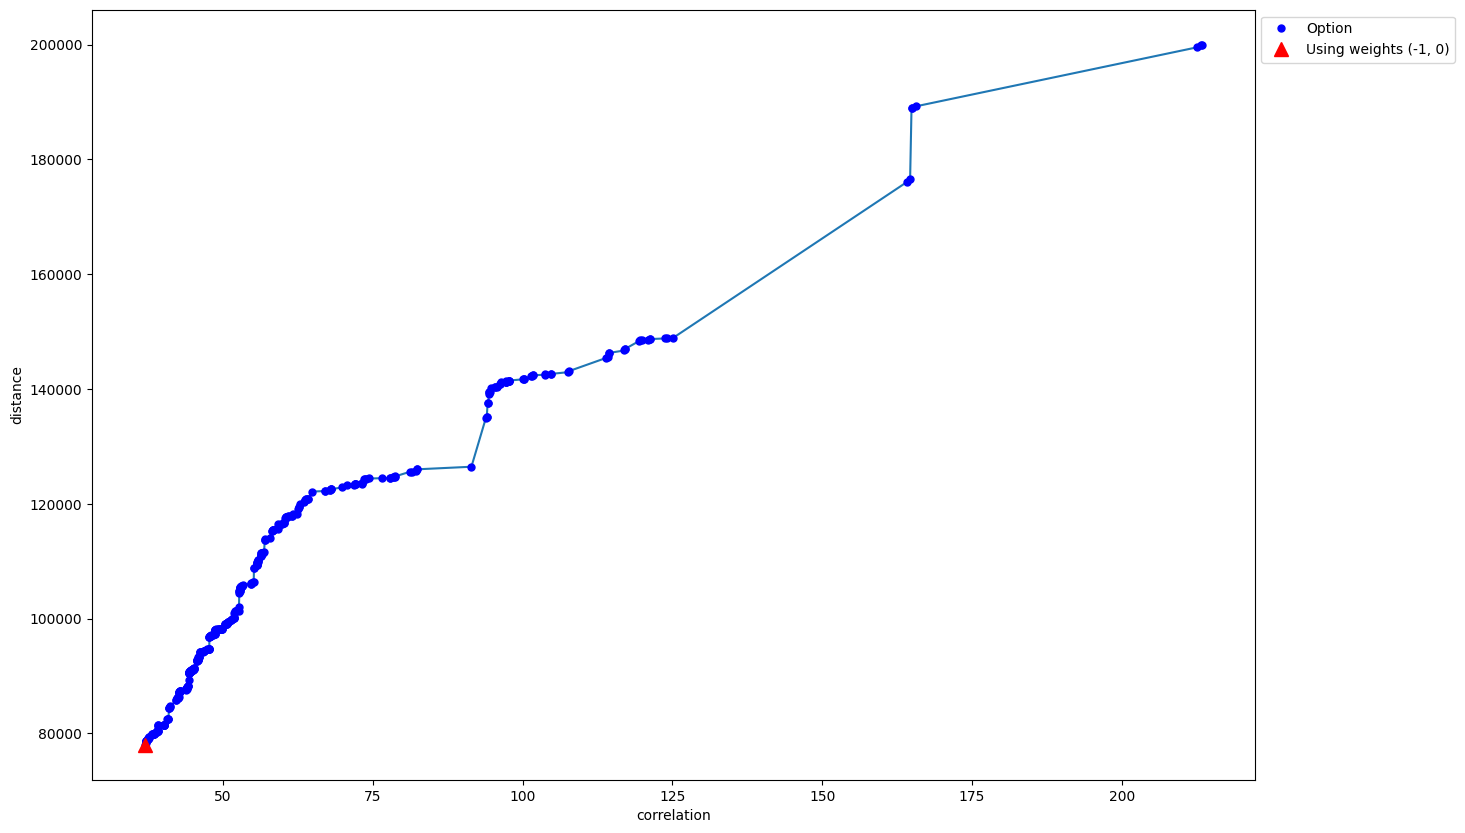

In [13]:
ag.plot(weights=(-1,0))

In [14]:
index = ag.select(index=0)

In [15]:
centroids_sc_pareto = centroids_sc_hv[index]

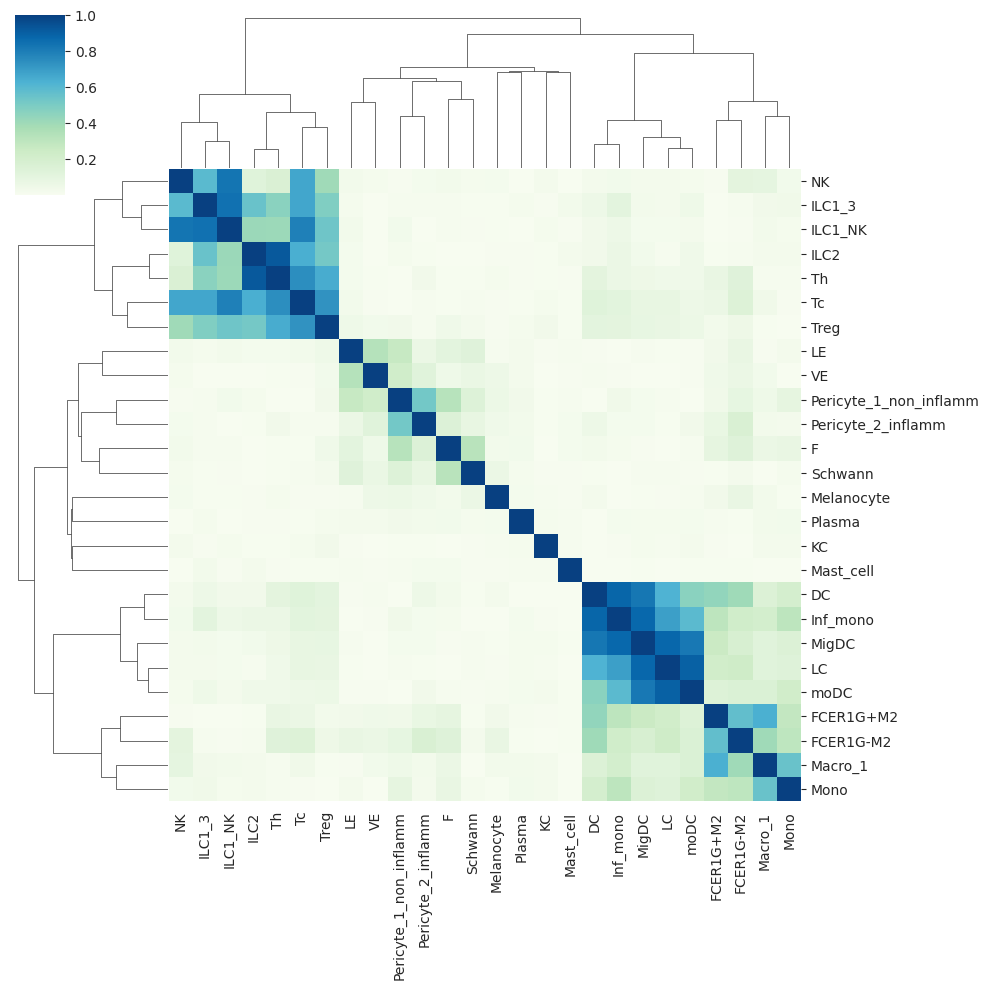

In [16]:
#Correlation matrix
corr = pd.DataFrame(data = np.corrcoef(centroids_sc_pareto.T), columns = centroids_sc_pareto.columns, index = centroids_sc_pareto.columns)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns_plot =sns.clustermap(np.abs(corr),cmap=sns.color_palette("GnBu", 1000), robust=True)

### Deconvolute bulk transcriptome data

In [17]:
import pandas as pd
import anndata
import scanpy as sc
import numpy as np

# Make a copy of the original data and exclude the last three columns
data_bulk_raw2 = data_bulk_raw.copy()
data_bulk_raw2 = data_bulk_raw2.iloc[:, :-3]

# Filter the rows based on index names containing "AD" or "CT"
data_bulk_raw2 = data_bulk_raw2[data_bulk_raw2.index.str.contains("AD|CT")]

# Create an AnnData object
b = anndata.AnnData(X=data_bulk_raw2)

# Normalize the total counts to 10^4
sc.pp.normalize_total(b, target_sum=10e4)

# Convert the AnnData object back to a DataFrame
c = pd.DataFrame(data=b.X, index=data_bulk_raw2.index, columns=data_bulk_raw2.columns)

# Deconvolution using NuSVR model
coef_nusvr = ag.deconvolve(c, model='nusvr')

# Normalize the proportions (ensuring no negative values and summing to 1)
def normalize_proportions(data, copy=True):
    if copy:
        data_copy = data.copy()
    else:
        data_copy = data
    
    # Set any negative values to 0
    data_copy[data_copy < 0] = 0
    
    # Normalize each row (sum to 1)
    for raw in data_copy.index:
        row_sum = data_copy.loc[raw].sum()
        data_copy.loc[raw] = np.divide(data_copy.loc[raw], row_sum)
    
    return data_copy

# Apply normalization to the NuSVR results
proportions_NuSVR = normalize_proportions(pd.DataFrame(data=coef_nusvr, columns=clusters, index=c.index), copy=False)

# Create lists for grouping and status extraction from index
Group_list = [proportions_NuSVR.index[i].split("_")[0] for i in range(len(proportions_NuSVR.index))]
status_list = [proportions_NuSVR.index[i].split("_")[2] for i in range(len(proportions_NuSVR.index))]

# Create a new index for grouping
idx = pd.DataFrame(Group_list, status_list)[0] + "_" + pd.DataFrame(Group_list, status_list).index
aa = proportions_NuSVR.copy()
aa.index = idx
grouped_mean = aa.groupby(aa.index).mean()


In [18]:
grouped_mean

,DC,KC,F,FCER1G+M2,FCER1G-M2,ILC1_3,ILC1_NK,ILC2,Inf_mono,LC,...,NK,Pericyte_1_non_inflamm,Pericyte_2_inflamm,Plasma,Schwann,Tc,Th,Treg,VE,moDC
AD_lesional,0.029175,0.595211,0.077218,0.001736,0.0,0.0,0.014549,0.001039,0.000227,0.000967,...,0.017602,0.000145,0.002349,0.000039,0.0,0.0,0.062402,0.006461,0.002883,0.016288
AD_non-lesional,0.026177,0.506895,0.155218,0.001650,0.0,0.0,0.026462,0.000426,0.001458,0.007523,...,0.009844,0.000017,0.005429,0.000024,0.0,0.0,0.089871,0.000656,0.002624,0.006493
CTRL_healthy,0.027506,0.495252,0.193838,0.000000,0.0,0.0,0.024355,0.000027,0.000334,0.007963,...,0.008896,0.000000,0.004137,0.000028,0.0,0.0,0.087614,0.000306,0.003954,0.002110
